In [1]:
%matplotlib notebook

The question I want to answer here is:

Once the Python code instructs to turn on/off the GPIO, how long does it take for the GPIO to actually be on? I couldn't find any citable source so I measured this doing the following:

1) I put a wildtype fly into a petri dish and recorded at 30fps. PiVR was running to present a checkerboard pattern in order to get a lot of GPIO ON and OFF instances

2) At the same time a script called 'self-listener.py' was running as fast as possible (just a for loop) while recording the status of the GPIO that is being turned ON/OFF by the fly in the virtual checkerboard.

3) The time was measured with time.time() which is (CPU) epoch time. As it's measured on the same Pi this allows for the direct calculation of the difference between time measured by the PiVR software and the time measured by the "self-listener.py" script!

Again, this is a very conservative measurement as PiVR is running while a second script is asking the GPIO for it's status thousands of times per second. 

The rest of the time it takes for the LED to be turned on should be neglible: The Transistor I used for the standard version has a rise time of < 500ns and a fall time of < 300ns (Datasheet: https://eu.mouser.com/datasheet/2/308/FQP30N06L-1306227.pdf). LEDs are being turned on and off in the 10-100s of nanosecond range as well. In total this should account for more than at most a couple of microseconds.


In [2]:
from IPython.display import Image
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
from glob import glob
from pathlib import Path

In [3]:
home_path = os.getcwd()

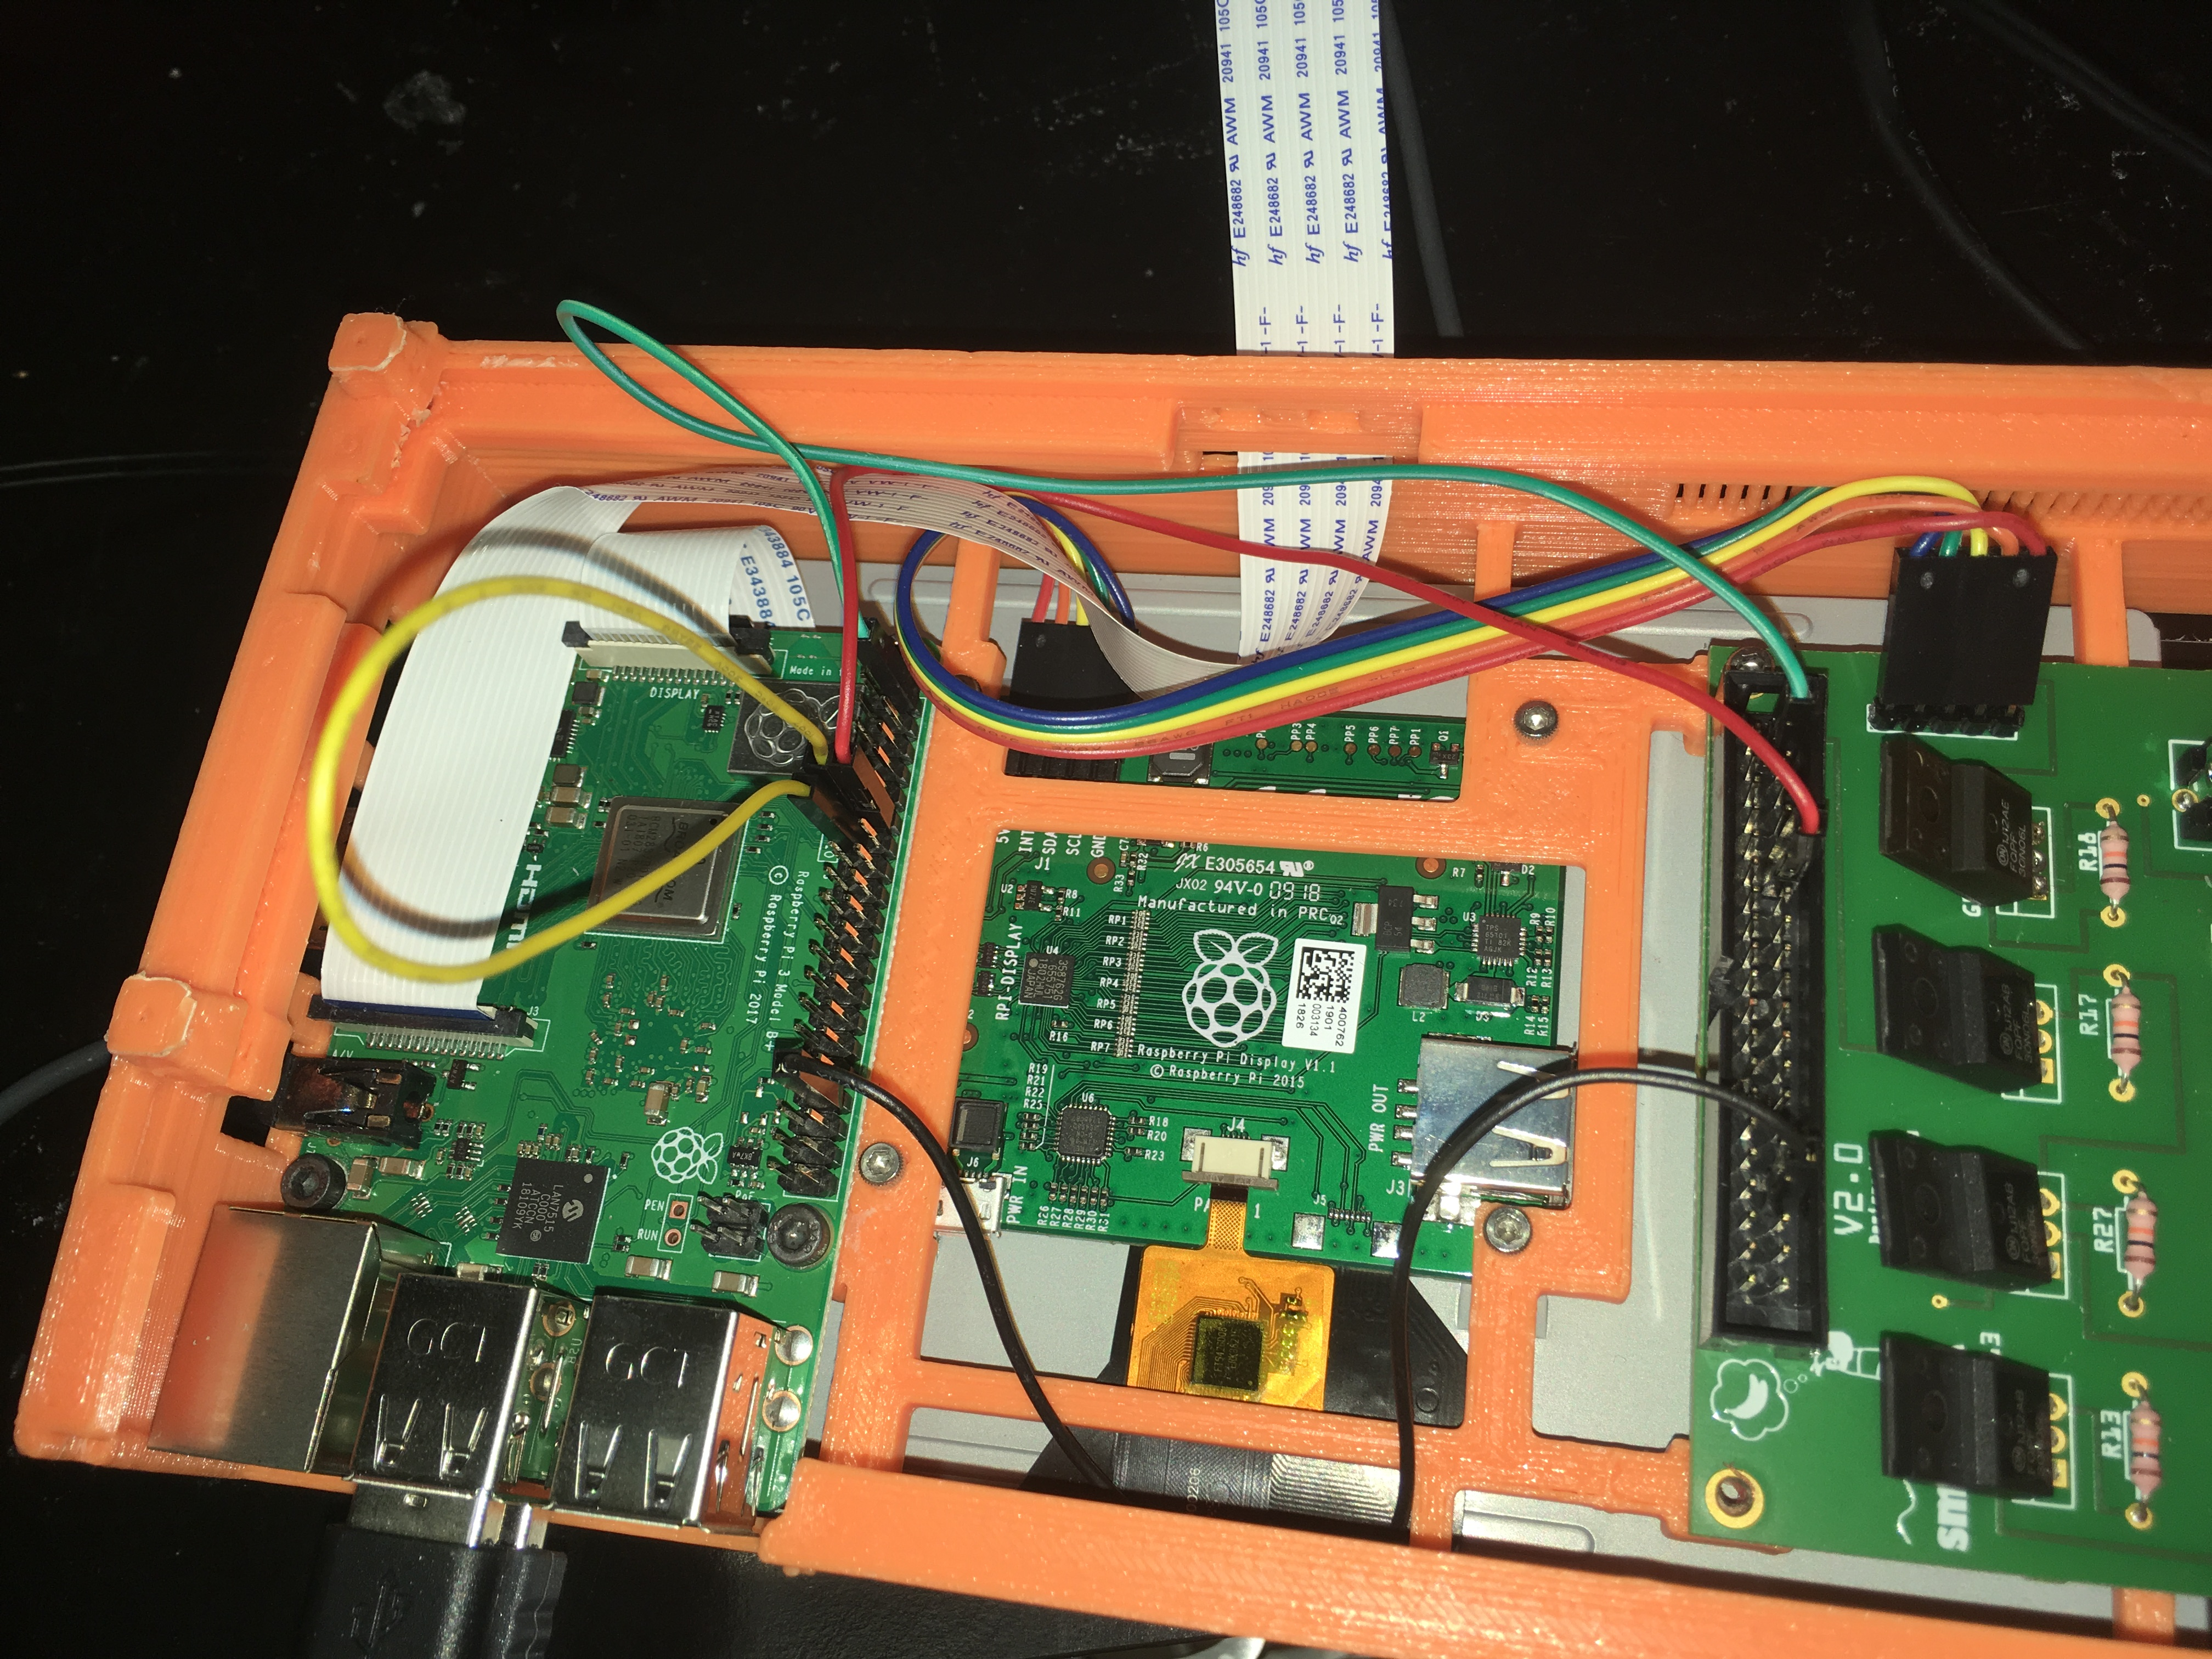

In [4]:
data_path = Path(home_path, 'data/benchmarking/GPIO_latency/2019.06.17_16-49-41_latency_test_arena_30fps/')
os.chdir(data_path)
target_path = Path(home_path, 'plots/Fig1S1')
os.makedirs(target_path, exist_ok=True)
# An image of the PiVR setup that was used. The black jumper cable is the ground. Green is 5V. Red is GPIO18.
# The yellow jumper is in GPIO17 and GPIO27 (this would not have been necessary as we changed status of GPIO17
# and recorded from GPIO17!)
Image(filename = "IMG_1334.JPG" , 
      width=500, height=500)

In [5]:
# get the loop timestamps (system time, got it with time.time())
loop_timestamps = np.load('loop_time.npy')

# get the csv file with the state of the GPIO
files = [p.replace('\\', '') for p in glob('*')]
for file in files:
    if 'data.csv' in file:
        data = pd.read_csv(file)
# change name of columns

# get the csv file with the timestamps of latency listener script (also system time, got it with time.time())
files = [p.replace('\\', '') for p in glob('*')]
for file in files:
    if 'latency.csv' in file:
        latency_data = pd.read_csv(file)
# change name of columns
latency_data.columns=['Time', 'State']

<IPython.core.display.Javascript object>


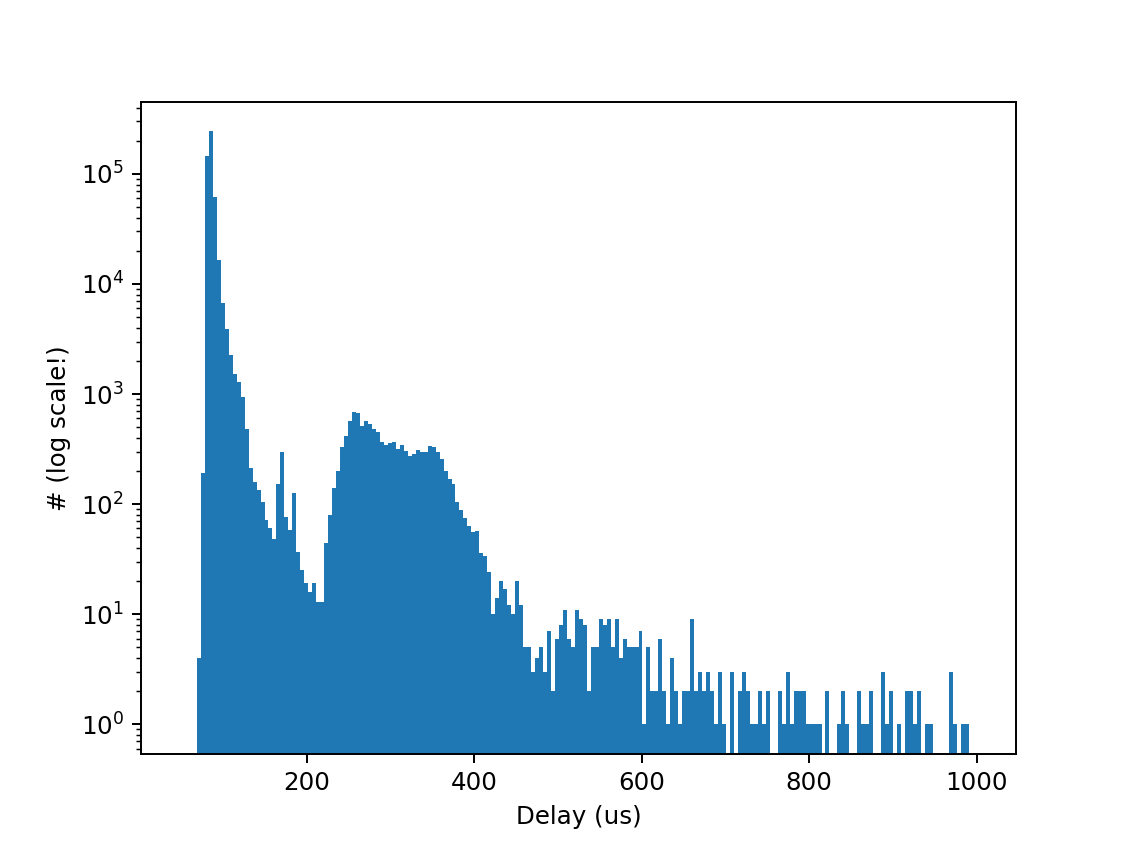

C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\numpy\lib\histograms.py:824: RuntimeWarning: invalid value encountered in greater_equal
  keep = (tmp_a >= first_edge)
C:\Users\David\AppData\Local\conda\conda\envs\pivr_publication\lib\site-packages\numpy\lib\histograms.py:825: RuntimeWarning: invalid value encountered in less_equal
  keep &= (tmp_a <= last_edge)


In [6]:
# As there is no way to control how fast the loop is running (it just runs as fast as possible) it would
# be great to get an idea how fast it actually is.
# Conclusion: The absolute vast majority is in the order of 80-100us. Some are between 200-400us and almost none
# are above that.
fig = plt.figure()
ax = fig.add_subplot(111)
ax.hist(latency_data['Time'].diff()*1000*1000, range = (50,1000), bins=200)
ax.set_ylabel('# (log scale!)')
ax.set_xlabel('Delay (us)')
ax.set_yscale('log')

In [7]:
# find all the low to high transition in data['stimulation'] (start_on)
# and vice versa (end_on)
start_on_supposed = []
end_on_supposed = []

previous_value = None

for counter, current_value in enumerate(data['stimulation']):
    if previous_value is None:
        start_on_supposed.append(counter)
    elif previous_value > 0 and current_value == 0:
        end_on_supposed.append(counter)
    elif previous_value == 0 and current_value > 0:
        start_on_supposed.append(counter)
    
    previous_value = current_value
    
# get the timestamp from time.time() that was called the line before the change of the GPIO
timepoint_ON_supposed = []
for i in start_on_supposed:
    timepoint_ON_supposed.append(loop_timestamps[i,1])
    
timepoint_OFF_supposed = []
for i in end_on_supposed:
    timepoint_OFF_supposed.append(loop_timestamps[i,1])

In [8]:
# now go to the listener, find all the transistion
start_on_measured = []
end_on_measured = []

previous_value = None

for counter, current_value in enumerate(latency_data['State']):
    if previous_value is None:
        start_on_measured.append(counter)
    elif previous_value > 0 and current_value == 0:
        end_on_measured.append(counter)
    elif previous_value == 0 and current_value > 0:
        start_on_measured.append(counter)
    
    previous_value = current_value
    
# get the timestamp from time.time() that was called the line before the change of the GPIO
timepoint_ON_measured = []
for i in start_on_measured:
    timepoint_ON_measured.append(latency_data['Time'][i])
    
timepoint_OFF_measured = []
for i in end_on_measured:
    timepoint_OFF_measured.append(latency_data['Time'][i])
    
# now normalize all the values! 
# take the loop_timestamps[0,1] as reference!
timepoint_ON_supposed_diff = np.array(timepoint_ON_supposed)- loop_timestamps[0,1]
timepoint_ON_measured_diff = np.array(timepoint_ON_measured) - loop_timestamps[0,1]

timepoint_OFF_supposed_diff = np.array(timepoint_OFF_supposed) - loop_timestamps[0,1]
timepoint_OFF_measured_diff = np.array(timepoint_OFF_measured) - loop_timestamps[0,1]


In [9]:
# find the first useful value - the problem is that the supposed and measured times are not aligned
# They can't really be as they have totally different loop times!
# Assumption here is that the first rise comes from supposed (not from measured!)
for i in range(timepoint_ON_measured_diff.shape[0]):
    diff_ON = timepoint_ON_measured_diff - timepoint_ON_supposed_diff[i:timepoint_ON_measured_diff.shape[0]+i]
    if diff_ON.mean() < 1:
        shift_array_by = i
        break
diff_ON_ms = diff_ON * 1000
diff_ON_us = diff_ON_ms *  1000


In [10]:
#timepoint_OFF_measured_diff
for i in range(timepoint_OFF_measured_diff.shape[0]):
    diff_OFF = timepoint_OFF_measured_diff - timepoint_OFF_supposed_diff[i:timepoint_OFF_measured_diff.shape[0]+i]
    if diff_OFF.mean() < 1:
        shift_array_by = i
        break
diff_OFF_ms = diff_OFF * 1000
diff_OFF_us = diff_OFF_ms * 1000

<IPython.core.display.Javascript object>


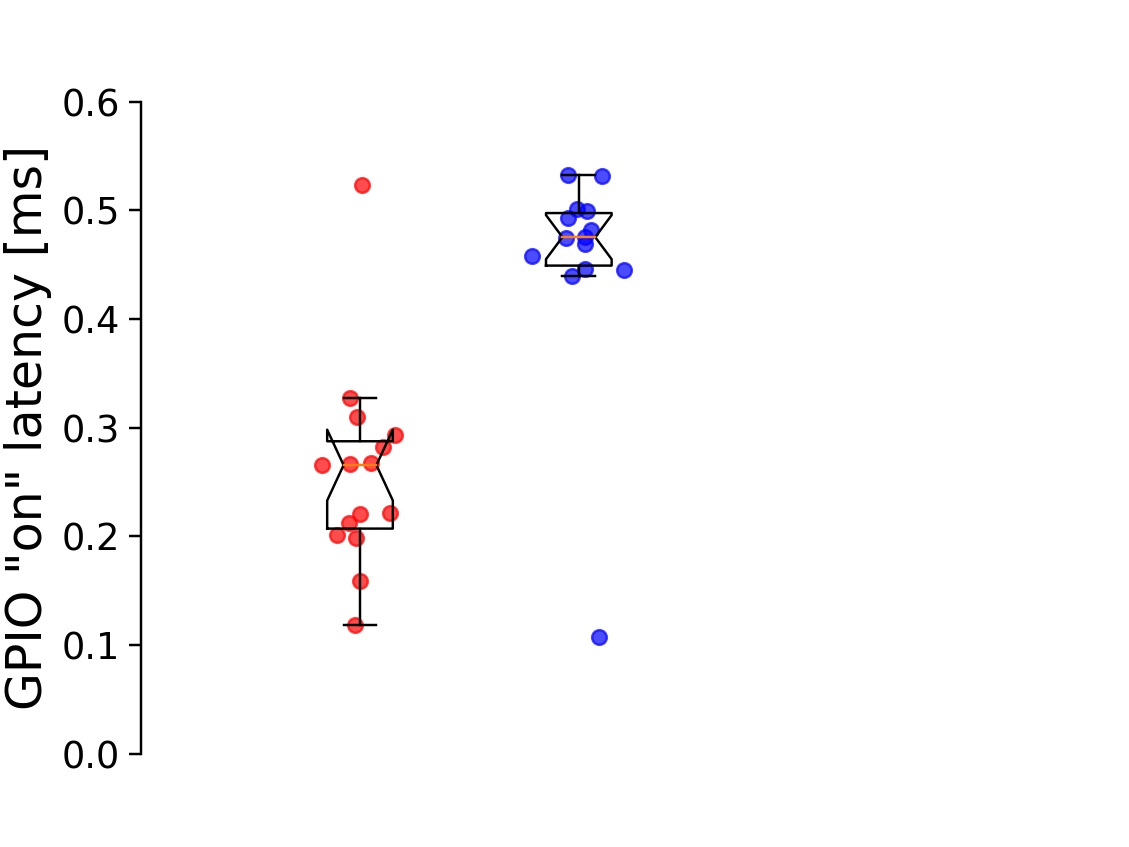

In [11]:
fig=plt.figure()
ax=fig.add_subplot(111)
ax.set_rasterization_zorder(1)
def boxplot_and_scatter(x_position, y_data,color, fps=None, boxplot=False):
    x_jittered = np.random.normal(x_position, 0.05, size=y_data.shape[0])
    ax.scatter(x=x_jittered, y=y_data, alpha=0.7, color=color, zorder=0)
    if boxplot:
        ax.boxplot(y_data, showfliers=False, positions=[x_position],notch=True,zorder=1)
    # plot the line indicating the maximum allowed loop time
    if fps is not None:
        ax.plot([x_position-0.2,x_position+0.2], [1/fps*1000, 1/fps*1000], c='k')

boxplot_and_scatter(0,diff_ON_ms[1::],color='r', boxplot=True)
boxplot_and_scatter(0.5, diff_OFF_ms,color ='b',boxplot=True)

#ax.set_xticklabels(['Light On','Light Off','Light On','Light Off'], fontsize=22, rotation=60)
ax.set_xticklabels([])
ax.set_ylabel('GPIO "on" latency [ms]', fontsize=20)

ax.set_ylim(0,0.6)
#ax.grid(alpha=0.5, axis='y')

# extend x axis to make space for legend
ax.set_xlim(-.5,1.5)

# get rid of ticks (bottom ticks)
ax.tick_params(
        #axis='x',          # changes apply to the x-axis
        which='both',      # both major and minor ticks are affected
        bottom=False,      # ticks along the bottom edge are off
        right=False,         # ticks along the left edge are off
        labelleft=True,   # labels along the left edge are off
        labelbottom=True
        ) 

# turn spines of everywhere except on the left
ax.spines['bottom'].set_visible(False)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_linewidth(1)
# modify spines on the left
ax.spines['left'].set_bounds(0,0.6)

# We change the fontsize of minor ticks label 
ax.tick_params(axis='both', which='major', width=1, length =5)
#ax.tick_params(axis='both', which='minor', width =2,length =3)
ax.tick_params(axis='y', labelsize=15)

# To save figure, uncomment the following line
# fig.savefig(Path(str(target_path), 'fig1S1d.eps'), rasterized=True, dpi=300)